In [22]:
## Note

# I think it would be helpful to predict the demand quantity for each part item (`niin_nomenclature`) for future dates, either aggregated by month or by day of the week. This will help with proactive inventory planning.

# I wonder whether specific months or days of the week consistently require more or less parts than others.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt



In [4]:
import os

downloads_path = os.path.expanduser("~/Downloads")
os.chdir(downloads_path)

print("Current Directory:", os.getcwd())


Current Directory: /Users/jasonchen/Downloads


In [5]:
hvacdata = pd.read_csv('hvac_merged.csv')


/var/folders/9f/3yz89nb525nczbywh5dl11kh0000gn/T/ipykernel_50162/1081890662.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  hvacdata = pd.read_csv('hvac_merged.csv')


In [7]:
hvacdata.head()



,uic,job_seq,apl,cause_code,cdm_rin,csmp_narrative_summary,date_closing,date_maintenance_action,deferral_reason_code,due_date,...,total_price,action_taken_code,loc1,loc2,loc3,loc4,cwtDays,totPrice,totMaterialCost,daysOpen
0,R03369,36493414,43A030026,7,86KYW,PARTS MISSING,2018-05-08,2018-07-16,2.0,NaN,...,50.92,1,2,200,01,Q,8.0,50.92,50.92,0.0
1,R03369,36493441,611330020,7,0KYWX,PARTS MISSING,2018-05-10,2018-07-16,2.0,NaN,...,10.35,1,2,180,0,L,8.0,10.35,10.35,0.0
2,R23170,36496418,611330020,7,0UXWY,PARTS MISSING,2018-05-29,2018-07-16,2.0,NaN,...,10.35,1,2,84,0,Q,8.0,10.35,10.35,0.0
3,R21853,36305764,18550014,7,02THE,PARTS BROKEN,2018-04-12,2018-05-11,2.0,NaN,...,20.00,1,03,148,2,Q,8.0,20.00,249.98,0.0
4,R21853,36305764,18550014,7,02THE,PARTS BROKEN,2018-04-12,2018-05-11,2.0,NaN,...,16.00,1,03,148,2,Q,8.0,16.00,249.98,0.0


In [8]:
hvacdata['demand_date'] = pd.to_datetime(hvacdata['demand_date'], errors='coerce')


In [11]:
# Exclude rows where niin_nomenclature is "Unknown"
demand_df = demand_df[demand_df['niin_nomenclature'].str.lower() != 'unknown']

print("Filtered shape:", demand_df.shape)
print("Top 5 unique parts after filtering:")
print(demand_df['niin_nomenclature'].value_counts().head())


Filtered shape: (34582, 73)
Top 5 unique parts after filtering:
niin_nomenclature
FILTER ELEMENT,AIR     12225
O-RING                  1445
BELT,V                  1015
BEARING,BALL,ANNULA      972
GASKET                   759
Name: count, dtype: int64


In [10]:
print("Shape of demand dataset:", demand_df.shape)
print("\nTop 5 rows:\n", demand_df[['demand_date', 'niin_nomenclature', 'quantity']].head())

Shape of demand dataset: (35194, 73)

Top 5 rows:
   demand_date niin_nomenclature  quantity
0  2018-06-22           Unknown       1.0
1  2018-06-22           Unknown       1.0
2  2018-06-25           Unknown       1.0
3  2018-04-16           Unknown       1.0
4  2018-04-16           Unknown       1.0


In [12]:
# most frequently requested parts
top_parts = demand_df['niin_nomenclature'].value_counts().head(10)
print("\nTop 10 most requested parts:\n", top_parts)


Top 10 most requested parts:
 niin_nomenclature
FILTER ELEMENT,AIR     12225
O-RING                  1445
BELT,V                  1015
BEARING,BALL,ANNULA      972
GASKET                   759
SWITCH,THERMOSTATIC      737
FILTER,AIR,DISPOSAB      697
LOUDSPEAKER,PERMANE      636
LAMP,INCANDESCENT        500
RELAY,ELECTROMAGNET      399
Name: count, dtype: int64


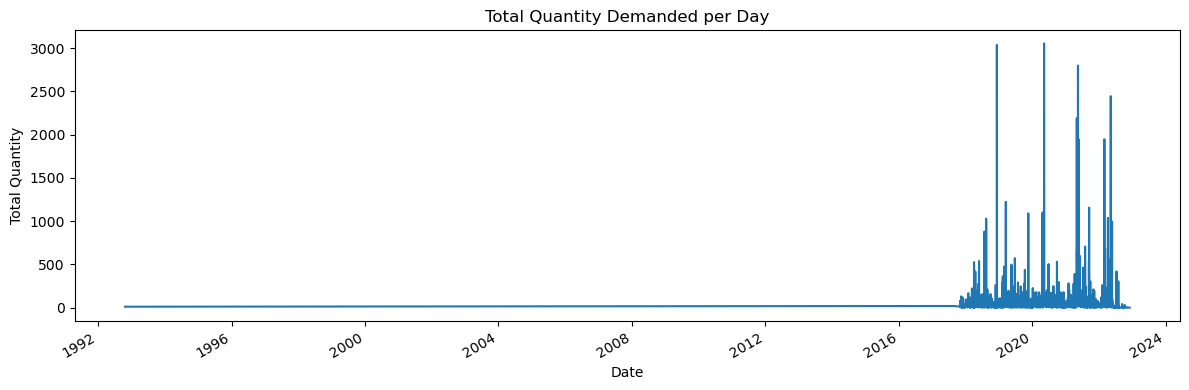

In [16]:
# quantity demanded over time
daily_demand = demand_df.groupby('demand_date')['quantity'].sum()

plt.figure(figsize=(12, 4))
daily_demand.plot()
plt.title("Total Quantity Demanded per Day")
plt.xlabel("Date")
plt.ylabel("Total Quantity")
plt.tight_layout()
plt.show()


In [18]:

print(demand_df.columns.tolist())



# new date features
demand_df['demand_year'] = demand_df['demand_date'].dt.year
demand_df['demand_month'] = demand_df['demand_date'].dt.month
demand_df['demand_dayofweek'] = demand_df['demand_date'].dt.day_name()

print(demand_df[['demand_date', 'demand_year', 'demand_month', 'demand_dayofweek']].head())


['uic', 'job_seq', 'apl', 'cause_code', 'cdm_rin', 'csmp_narrative_summary', 'date_closing', 'date_maintenance_action', 'deferral_reason_code', 'due_date', 'eic', 'equipment_nomenclature', 'eswbs_opening', 'iuc_screening_code', 'location', 'mhc', 'mho', 'mhr', 'priority_code', 'safety_code', 'status_code', 'tycom_screening_code', 'type_availability_code', 'type_of_maintenance_action', 'when_discovered_code', 'work_center', 'total_ima_man_hours', 'total_ship_force_man_hours', 'total_replacement_cost', 'total_repair_replacement_cost', 'def_narrative', 'nondef_narrative', 'closing_narrative', 'ima_narrative', 'total_material_cost', 'opening_ship_system', 'job_status', 'days_open', 'action_taken', 'intermediate_unit_commander_screening', 'priority', 'type_of_availability_needed', 'tycom_screening', 'when_discovered', 'cause', 'deferral_reason', 'feasible_with_ship_inventory', 'feasible_with_additional_dla_inventory', 'ship', 'uic_s', 'jsn', 'date_closing_s', 'demand_date', 'issue_date', 'c

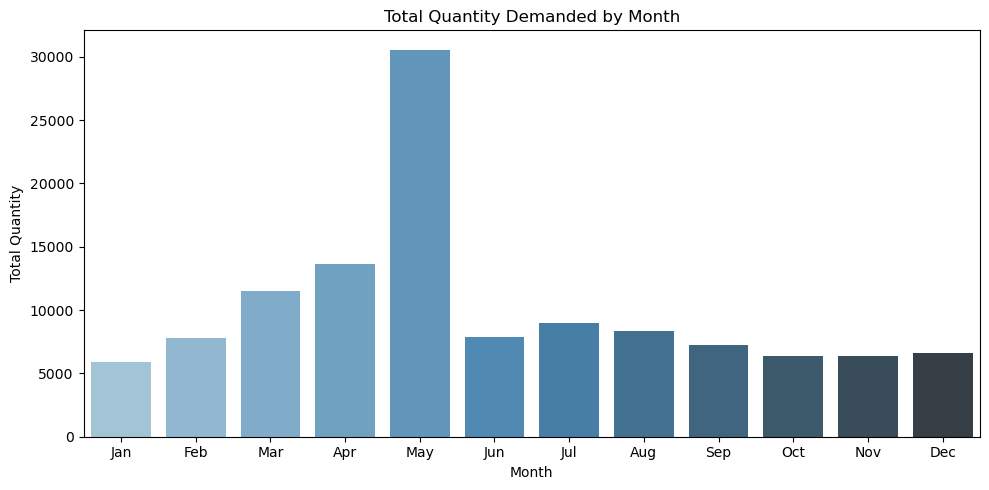

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# total quantity by month
monthly_demand = demand_df.groupby('demand_month')['quantity'].sum().reindex(range(1,13))

plt.figure(figsize=(10,5))
sns.barplot(x=monthly_demand.index, y=monthly_demand.values, palette='Blues_d')
plt.title("Total Quantity Demanded by Month")
plt.xlabel("Month")
plt.ylabel("Total Quantity")
plt.xticks(ticks=range(0,12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.tight_layout()
plt.show()


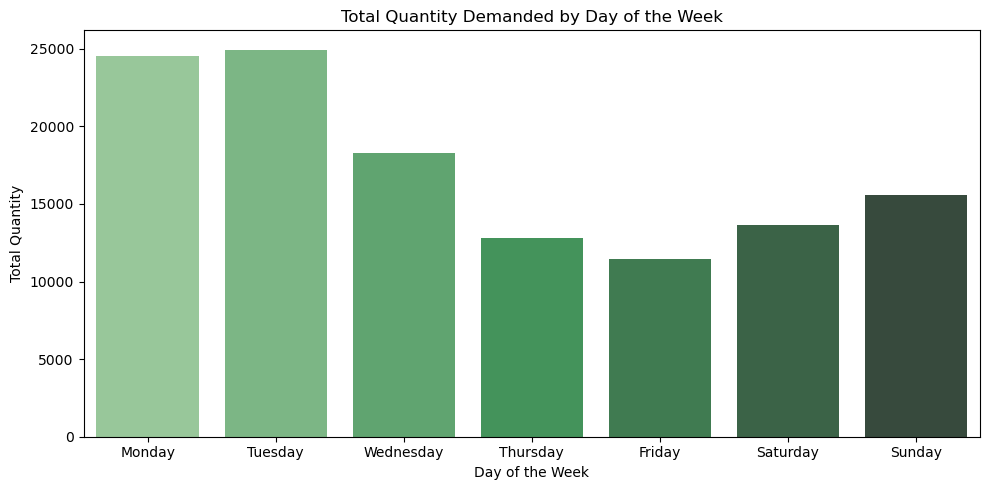

In [20]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_demand = demand_df.groupby('demand_dayofweek')['quantity'].sum().reindex(day_order)

plt.figure(figsize=(10,5))
sns.barplot(x=dow_demand.index, y=dow_demand.values, palette='Greens_d')
plt.title("Total Quantity Demanded by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Total Quantity")
plt.tight_layout()
plt.show()


In [ ]:
# test line